In [1]:
import pandas as pd
import numpy as np
import re, os
from string import printable
from sklearn import model_selection
import tensorflow as tf
from keras.models import Sequential, Model, model_from_json, load_model
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation, Lambda, Flatten
from keras.layers import Input, ELU, LSTM, Embedding, Convolution2D, MaxPooling2D, \
BatchNormalization, Convolution1D, MaxPooling1D, concatenate
from keras.preprocessing import sequence
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import backend as K
from pathlib import Path
import json
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

Using TensorFlow backend.



## Deep Learning 


Requirements:

- tensorflow 1.4.1
- keras 2.1.2


## Preprocess 

In [2]:
## Load data code_snippet
DATA_HOME = 'CNN Binary Classification/'
Al_Boghdady_Binary_Dataset = pd.read_csv('Al_Boghdady_Binary.csv', encoding= 'unicode_escape')
Al_Boghdady_Binary_Dataset.sample(n=5).head(5) 

,code,isMalicious
3171,staticvoid G1 ( ) { { int int One = ...,0
391,void bad ( ) { if ( GLOBAL_CONST_FALSE )...,1
1434,void PMC_EnableAllPeripherals(void) { AT91C_BA...,1
2183,void bad ( ) { char * data ; char * data...,1
3108,char buf [256] ;,1


In [3]:
#Dataset Shape
Al_Boghdady_Binary_Dataset.shape

(5080, 2)

In [4]:
# Checking for duplicate rows or null values
Al_Boghdady_Binary_Dataset.dropna(inplace=True)
Al_Boghdady_Binary_Dataset.drop_duplicates(inplace=True)
Al_Boghdady_Binary_Dataset.sample(n=5).head(5) 

,code,isMalicious
3711,staticvoid G2 ( ) { if ( staticFive ==...,0
824,if ( incr4 != 0 ) { uint32_t begin = ( ui...,1
1699,else { dcoConst = * ( ( float * ) &cs -> r...,1
396,void bad ( ) { int int Rande = rand ...,1
404,noise_hash -> size = NOISE_DEFAULT_ELEMENT_S...,1


In [5]:
#Dataset Shape
Al_Boghdady_Binary_Dataset.shape

(4774, 2)

In [6]:
#Dataset tokenization
code_snippet_int_tokens = [[printable.index(x) + 1 for x in code_snippet if x in printable] 
                           for code_snippet in Al_Boghdady_Binary_Dataset.code]
max_len = 150
X = sequence.pad_sequences(code_snippet_int_tokens, maxlen=max_len)
target = np.array (Al_Boghdady_Binary_Dataset.isMalicious)
print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

Matrix dimensions of X:  (4774, 150) Vector dimension of target:  (4774,)


In [7]:
# Split the data set into training and test data
X_train, X_test, target_train, target_test = model_selection.train_test_split(X, target, test_size=0.30, random_state=30)

In [8]:
# Layer dimensions
def print_layers_dims(model):
    l_layers = model.layers
    # Note None is ALWAYS batch_size
    for i in range(len(l_layers)):
        print(l_layers[i])
        print('Input Shape: ', l_layers[i].input_shape, 'Output Shape: ', l_layers[i].output_shape)

#Save model to disk
def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    #have h5py installed
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)
    

#load model from disk
def load_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    with open(fileModelJSON, 'r') as f:
         model_json = json.load(f)
         model = model_from_json(model_json)
    
    model.load_weights(fileWeights)
    return model

## Training Model 2 - 1D Convolutions and Fully Connected Layers

In [9]:
#CNN Model for Binary Classification

def CNN(max_len=150, emb_dim=32, max_vocab_len=150, W_reg=regularizers.l2(1e-4)):
    # Input
    main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
    # Embedding layer
    emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                W_regularizer=W_reg)(main_input) 
    emb = Dropout(0.25)(emb)

    
    def sum_1d(X):
        return K.sum(X, axis=1)
    
    def get_conv_layer(emb, kernel_size=5, filters=150):
        # Conv layer
        conv = Convolution1D(kernel_size=kernel_size, filters=filters, \
                     border_mode='same')(emb)
        conv = ELU()(conv)

        conv = Lambda(sum_1d, output_shape=(filters,))(conv)
        #conv = BatchNormalization(mode=0)(conv)
        conv = Dropout(0.5)(conv)
        return conv
    
        # Multiple Conv Layers
    # calling custom conv function from above
    conv1 = get_conv_layer(emb, kernel_size=2, filters=150)
    conv2 = get_conv_layer(emb, kernel_size=3, filters=150)
    conv3 = get_conv_layer(emb, kernel_size=4, filters=150)
    conv4 = get_conv_layer(emb, kernel_size=5, filters=150)

    # Fully Connected Layers
    merged = concatenate([conv1,conv2,conv3,conv4], axis=1)

    hidden1 = Dense(1024)(merged)
    hidden1 = ELU()(hidden1)
    hidden1 = BatchNormalization(mode=0)(hidden1)
    hidden1 = Dropout(0.5)(hidden1)

    hidden2 = Dense(1024)(hidden1)
    hidden2 = ELU()(hidden2)
    hidden2 = BatchNormalization(mode=0)(hidden2)
    hidden2 = Dropout(0.5)(hidden2)
      
        # Output layer (last fully connected layer)
    output = Dense(55, activation='softmax', name='output')(hidden2)
    
        # Compile model and define optimizer
    model = Model(input=[main_input], output=[output])
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
model = CNN()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 32)      4800        main_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 150, 32)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 150, 150)     9750        dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

Epoch 1/800
3341/3341 [==============================] - 23s 7ms/step - loss: 3.2242 - acc: 0.5214
Epoch 2/800
3341/3341 [==============================] - 17s 5ms/step - loss: 2.1402 - acc: 0.7357
Epoch 3/800
3341/3341 [==============================] - 17s 5ms/step - loss: 1.6308 - acc: 0.8141
Epoch 4/800
3341/3341 [==============================] - 17s 5ms/step - loss: 1.3681 - acc: 0.8482
Epoch 5/800
3341/3341 [==============================] - 17s 5ms/step - loss: 1.1208 - acc: 0.8683
Epoch 6/800
3341/3341 [==============================] - 19s 6ms/step - loss: 0.8995 - acc: 0.8812
Epoch 7/800
3341/3341 [==============================] - 20s 6ms/step - loss: 0.7939 - acc: 0.8884
Epoch 8/800
3341/3341 [==============================] - 20s 6ms/step - loss: 0.7599 - acc: 0.8890
Epoch 9/800
3341/3341 [==============================] - 19s 6ms/step - loss: 0.6643 - acc: 0.8931
Epoch 10/800
3341/3341 [==============================] - 19s 6ms/step - loss: 0.6121 - acc: 0.8955
Epoch 11/

3341/3341 [==============================] - 18s 6ms/step - loss: 0.1812 - acc: 0.9333
Epoch 84/800
3341/3341 [==============================] - 18s 5ms/step - loss: 0.1884 - acc: 0.9279
Epoch 85/800
3341/3341 [==============================] - 17s 5ms/step - loss: 0.1808 - acc: 0.9374
Epoch 86/800
3341/3341 [==============================] - 17s 5ms/step - loss: 0.1690 - acc: 0.9410
Epoch 87/800
3341/3341 [==============================] - 17s 5ms/step - loss: 0.1512 - acc: 0.9482
Epoch 88/800
3341/3341 [==============================] - 18s 5ms/step - loss: 0.1602 - acc: 0.9410
Epoch 89/800
3341/3341 [==============================] - 18s 6ms/step - loss: 0.1857 - acc: 0.9365
Epoch 90/800
3341/3341 [==============================] - 20s 6ms/step - loss: 0.1693 - acc: 0.9395
Epoch 91/800
3341/3341 [==============================] - 21s 6ms/step - loss: 0.1657 - acc: 0.9446
Epoch 92/800
3341/3341 [==============================] - 21s 6ms/step - loss: 0.1689 - acc: 0.9377
Epoch 93/800


3341/3341 [==============================] - 17s 5ms/step - loss: 0.0778 - acc: 0.9692
Epoch 246/800
3341/3341 [==============================] - 17s 5ms/step - loss: 0.0701 - acc: 0.9752
Epoch 247/800
3341/3341 [==============================] - 19s 6ms/step - loss: 0.0753 - acc: 0.9746
Epoch 248/800
3341/3341 [==============================] - 20s 6ms/step - loss: 0.0742 - acc: 0.9734
Epoch 249/800
3341/3341 [==============================] - 20s 6ms/step - loss: 0.0716 - acc: 0.9725
Epoch 250/800
3341/3341 [==============================] - 22s 7ms/step - loss: 0.0789 - acc: 0.9686
Epoch 251/800
3341/3341 [==============================] - 19s 6ms/step - loss: 0.0764 - acc: 0.9725
Epoch 252/800
3341/3341 [==============================] - 20s 6ms/step - loss: 0.0853 - acc: 0.9692
Epoch 253/800
3341/3341 [==============================] - 21s 6ms/step - loss: 0.0733 - acc: 0.9731
Epoch 254/800
3341/3341 [==============================] - 17s 5ms/step - loss: 0.0738 - acc: 0.9746
Epoc

3341/3341 [==============================] - 22s 7ms/step - loss: 0.0622 - acc: 0.9758
Epoch 408/800
3341/3341 [==============================] - 19s 6ms/step - loss: 0.0626 - acc: 0.9755
Epoch 409/800
3341/3341 [==============================] - 22s 7ms/step - loss: 0.0565 - acc: 0.9779
Epoch 410/800
3341/3341 [==============================] - 21s 6ms/step - loss: 0.0580 - acc: 0.9799
Epoch 411/800
3341/3341 [==============================] - 21s 6ms/step - loss: 0.0549 - acc: 0.9814
Epoch 412/800
3341/3341 [==============================] - 23s 7ms/step - loss: 0.0563 - acc: 0.9787
Epoch 413/800
3341/3341 [==============================] - 20s 6ms/step - loss: 0.0502 - acc: 0.9811
Epoch 414/800
3341/3341 [==============================] - 21s 6ms/step - loss: 0.0605 - acc: 0.9787
Epoch 415/800
3341/3341 [==============================] - 22s 7ms/step - loss: 0.0562 - acc: 0.9782
Epoch 416/800
3341/3341 [==============================] - 22s 7ms/step - loss: 0.0618 - acc: 0.9793
Epoc

3341/3341 [==============================] - 9s 3ms/step - loss: 0.0429 - acc: 0.9838
Epoch 570/800
3341/3341 [==============================] - 9s 3ms/step - loss: 0.0604 - acc: 0.9793
Epoch 571/800
3341/3341 [==============================] - 9s 3ms/step - loss: 0.0561 - acc: 0.9761
Epoch 572/800
3341/3341 [==============================] - 10s 3ms/step - loss: 0.0501 - acc: 0.9802
Epoch 573/800
3341/3341 [==============================] - 8s 2ms/step - loss: 0.0471 - acc: 0.9817
Epoch 574/800
3341/3341 [==============================] - 10s 3ms/step - loss: 0.0500 - acc: 0.9853
Epoch 575/800
3341/3341 [==============================] - 8s 2ms/step - loss: 0.0477 - acc: 0.9835
Epoch 576/800
3341/3341 [==============================] - 9s 3ms/step - loss: 0.0516 - acc: 0.9808
Epoch 577/800
3341/3341 [==============================] - 9s 3ms/step - loss: 0.0462 - acc: 0.9844
Epoch 578/800
3341/3341 [==============================] - 9s 3ms/step - loss: 0.0471 - acc: 0.9832
Epoch 579/80

3341/3341 [==============================] - 9s 3ms/step - loss: 0.0471 - acc: 0.9826
Epoch 732/800
3341/3341 [==============================] - 8s 2ms/step - loss: 0.0465 - acc: 0.9835
Epoch 733/800
3341/3341 [==============================] - 9s 3ms/step - loss: 0.0412 - acc: 0.9865
Epoch 734/800
3341/3341 [==============================] - 8s 2ms/step - loss: 0.0461 - acc: 0.9850
Epoch 735/800
3341/3341 [==============================] - 9s 3ms/step - loss: 0.0429 - acc: 0.9841
Epoch 736/800
3341/3341 [==============================] - 9s 3ms/step - loss: 0.0431 - acc: 0.9832
Epoch 737/800
3341/3341 [==============================] - 8s 3ms/step - loss: 0.0429 - acc: 0.9814
Epoch 738/800
3341/3341 [==============================] - 10s 3ms/step - loss: 0.0453 - acc: 0.9829
Epoch 739/800
3341/3341 [==============================] - 8s 2ms/step - loss: 0.0462 - acc: 0.9832
Epoch 740/800
3341/3341 [==============================] - 10s 3ms/step - loss: 0.0501 - acc: 0.9826
Epoch 741/80

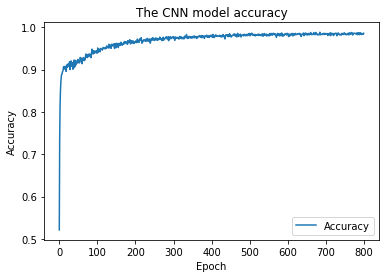


Final Cross-Validation Accuracy of CNN training model 0.9581297976273552 



In [11]:
# Fit model and Cross-Validation, Training Model 2 CONV + FULLY CONNECTED
CNN_model = CNN()
history = CNN_model.fit(X_train, target_train, epochs=800, batch_size=64)
loss, accuracy = CNN_model.evaluate(X_test, target_test, verbose=1)

print(history.history.keys())
plt.plot(history.history['acc'])
#plt.plot(history.history['loss'])
plt.title('The CNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='lower right')
plt.show()

print('\nFinal Cross-Validation Accuracy of CNN training model', accuracy, '\n')